# 프로젝트: 모든 장르 간 편향성 측정해보기

### 목차

1. 형태소 분석기를 이용해 명사 추출하기
2. 추출된 결과로 임베딩 모델 만들기
3. target, attribute 단어 셋 만들기
4. WEAT score 계산 및 시각화

In [10]:
import os

import numpy as np
from numpy import dot
from numpy.linalg import norm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

from konlpy.tag import Okt
from gensim.models import Word2Vec

### 데이터
- [영화 시놉시스 데이터](https://d3s0tskafalll9.cloudfront.net/media/documents/synopsis.zip)

<hr>

## 1. 형태소 분석기를 이용해 명사 추출하기

In [5]:
file_path = os.getenv('HOME')+'/aiffel/aiffel_projects/goingdeeper/GD6_weat'

In [2]:
okt = Okt()
tokenized = []

with open(file_path + '/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        
        res = []
        for w in words:
            if w[1] in ['Noun']:
                res.append(w[0])
            tokenized.append(res)

In [3]:
print(len(tokenized))

3168454


## 2. 추출된 결과로 임베딩 모델 만들기

In [6]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('이야기', 0.5952963829040527),
 ('감수성', 0.5618667006492615),
 ('작품', 0.5505588054656982),
 ('렌즈', 0.5261512994766235),
 ('삽입', 0.50557941198349),
 ('울림', 0.503958523273468),
 ('베르톨루치', 0.4953693449497223),
 ('군더더기', 0.4922523498535156),
 ('공감', 0.4898541569709778),
 ('영상', 0.48979371786117554)]

In [7]:
model.wv.most_similar(positive=['연극'])

[('교향', 0.5667837262153625),
 ('뮤지컬', 0.5549376010894775),
 ('출연', 0.5489833950996399),
 ('배우', 0.54713374376297),
 ('환상곡', 0.5322899222373962),
 ('주연', 0.517068088054657),
 ('베드', 0.504427433013916),
 ('보집', 0.4962136149406433),
 ('태산', 0.49329251050949097),
 ('공연', 0.4864543080329895)]

## 3. TF-IDF로 단어 셋 만들기

- 예술 영화와 상업 영화라는 구분을 target으로, 장르 구분을 attribute으로 삼아서 WEAT score 계산해보자.

- 영화 구분
    - synopsis_art.txt : 예술영화
    - synopsis_gen.txt : 일반영화(상업영화)
    - 그 외는 독립영화 등으로 분류됩니다.
- 장르 구분
    - synopsis_SF.txt: SF
    - synopsis_가족.txt: 가족
    - synopsis_공연.txt: 공연
    - synopsis_공포(호러).txt: 공포(호러)
    - synopsis_기타.txt: 기타
    - synopsis_다큐멘터리.txt: 다큐멘터리
    - synopsis_드라마.txt: 드라마
    - synopsis_멜로로맨스.txt: 멜로로맨스
    - synopsis_뮤지컬.txt: 뮤지컬
    - synopsis_미스터리.txt: 미스터리
    - synopsis_범죄.txt: 범죄
    - synopsis_사극.txt: 사극
    - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
    - synopsis_성인물(에로).txt: 성인물(에로)
    - synopsis_스릴러.txt: 스릴러
    - synopsis_애니메이션.txt: 애니메이션
    - synopsis_액션.txt: 액션
    - synopsis_어드벤처.txt: 어드벤처
    - synopsis_전쟁.txt: 전쟁
    - synopsis_코미디.txt: 코미디
    - synopsis_판타지.txt: 판타지

In [8]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    
    with open(os.getenv('HOME') + '/aiffel/aiffel_projects/goingdeeper/GD6_weat/' + file_name, 'r') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            
            for word in tokenlist:
                if word[1] in ['Noun']:
                    result.append((word[0]))
        return ' '.join(result)

In [9]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [12]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [15]:
# 각 단어 셋이 중복되지 않도록 중복 단어는 제외하고
# 상위 n개의 단어를 추출
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [16]:
# 추출된 단어 보기
print('예술 영화 대표 단어:\n', target_art)
print('\n상업 영화 대표 단어:\n', target_gen)

예술 영화 대표 단어:
 ['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']

상업 영화 대표 단어:
 ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [34]:
# 장르별 대표 단어 추출
genre_txt = [_ for _ in os.listdir(file_path) if _.endswith('.txt')]

print(genre_txt)

['synopsis_gen.txt', 'synopsis_adventure.txt', 'synopsis_musical.txt', 'synopsis_mystery.txt', 'synopsis_war.txt', 'synopsis_show.txt', 'synopsis_etc.txt', 'synopsis_adult.txt', 'synopsis_crime.txt', 'synopsis_documentary.txt', 'synopsis_horror.txt', 'synopsis_thriller.txt', 'synopsis_historical.txt', 'synopsis.txt', 'synopsis_art.txt', 'synopsis_western.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_animation.txt', 'synopsis_fantasy.txt', 'synopsis_comedy.txt', 'synopsis_family.txt', 'synopsis_SF.txt', 'synopsis_action.txt']


In [36]:
genre_txt.remove('synopsis.txt')
genre_txt.remove('synopsis_gen.txt')
genre_txt.remove('synopsis_art.txt')
genre_txt.sort()

len(genre_txt)

21

In [37]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.


In [38]:
genre_name = ['SF', '액션', '성인물(에로)', '어드벤처', '애니메이션', '코미디', '범죄', '다큐멘터리', '드라마', '기타', '가족', '판타지', '사극', '공포(호러)', '뮤지컬', '미스터리', '멜로로맨스', '공연', '스릴러', '전쟁', '서부극(웨스턴)']

print(len(genre_name))

21


In [39]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [42]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print('\n')

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 

액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 모든, 목숨, 사실, 친구, 가족, 요원, 

성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 

어드벤처: 위해, 자신, 시작, 친구, 마을, 아버지, 영화, 아이, 사람, 여행, 세계, 앤트, 세상, 가족, 모험, 

애니메이션: 애니메이션, 국제, 영화제, 친구, 인디애니페스트, 위해, 자신, 시작, 사람, 페스티벌, 서울, 이야기, 아이, 마을, 소녀, 

코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 

범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 

다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 

드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 

기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 

가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 

판타지: 자신, 그녀, 시작, 위해, 사람, 사랑, 요괴, 영화제, 이야기, 영화, 소녀, 남자, 인간, 세상, 마을, 

사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 

공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 

뮤지컬: 뮤지컬, 사랑, 에스메

## 4. WEAT score 계산 및 시각화

In [46]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [47]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [48]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [49]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(f"{genre_name[i]} & {genre_name[j]}: {matrix[i][j]: >6.4f}")

SF & 액션: -0.7407
SF & 성인물(에로): -0.5227
SF & 어드벤처: -0.8800
SF & 애니메이션: -0.1240
SF & 코미디: -0.9064
SF & 범죄: -0.3686
SF & 다큐멘터리: 0.5482
SF & 드라마: -0.7514
SF & 기타: 0.0153
SF & 가족: -0.9808
SF & 판타지: -0.5435
SF & 사극: -1.3098
SF & 공포(호러): -0.9018
SF & 뮤지컬: -0.0705
SF & 미스터리: -0.7928
SF & 멜로로맨스: -0.8143
SF & 공연: -0.7143
SF & 스릴러: -0.5549
SF & 전쟁: -0.4093
SF & 서부극(웨스턴): -0.9522
액션 & 성인물(에로): -0.1314
액션 & 어드벤처: -0.0709
액션 & 애니메이션: 0.3814
액션 & 코미디: -0.2603
액션 & 범죄: 0.6469
액션 & 다큐멘터리: 0.6838
액션 & 드라마: -0.1698
액션 & 기타: 0.4440
액션 & 가족: -0.5105
액션 & 판타지: 0.1660
액션 & 사극: -0.4476
액션 & 공포(호러): -0.3758
액션 & 뮤지컬: 0.3067
액션 & 미스터리: -0.4054
액션 & 멜로로맨스: -0.5293
액션 & 공연: -0.0410
액션 & 스릴러: -0.0712
액션 & 전쟁: 0.3419
액션 & 서부극(웨스턴): -0.2233
성인물(에로) & 어드벤처: 0.0869
성인물(에로) & 애니메이션: 0.4791
성인물(에로) & 코미디: -0.0186
성인물(에로) & 범죄: 0.3279
성인물(에로) & 다큐멘터리: 0.7605
성인물(에로) & 드라마: -0.0076
성인물(에로) & 기타: 0.6332
성인물(에로) & 가족: -0.2433
성인물(에로) & 판타지: 0.3477
성인물(에로) & 사극: -0.1362
성인물(에로) & 공포(호러): -0.0388
성인물(에로) & 뮤지컬: 0.4499
성인물(에로)

<AxesSubplot:>

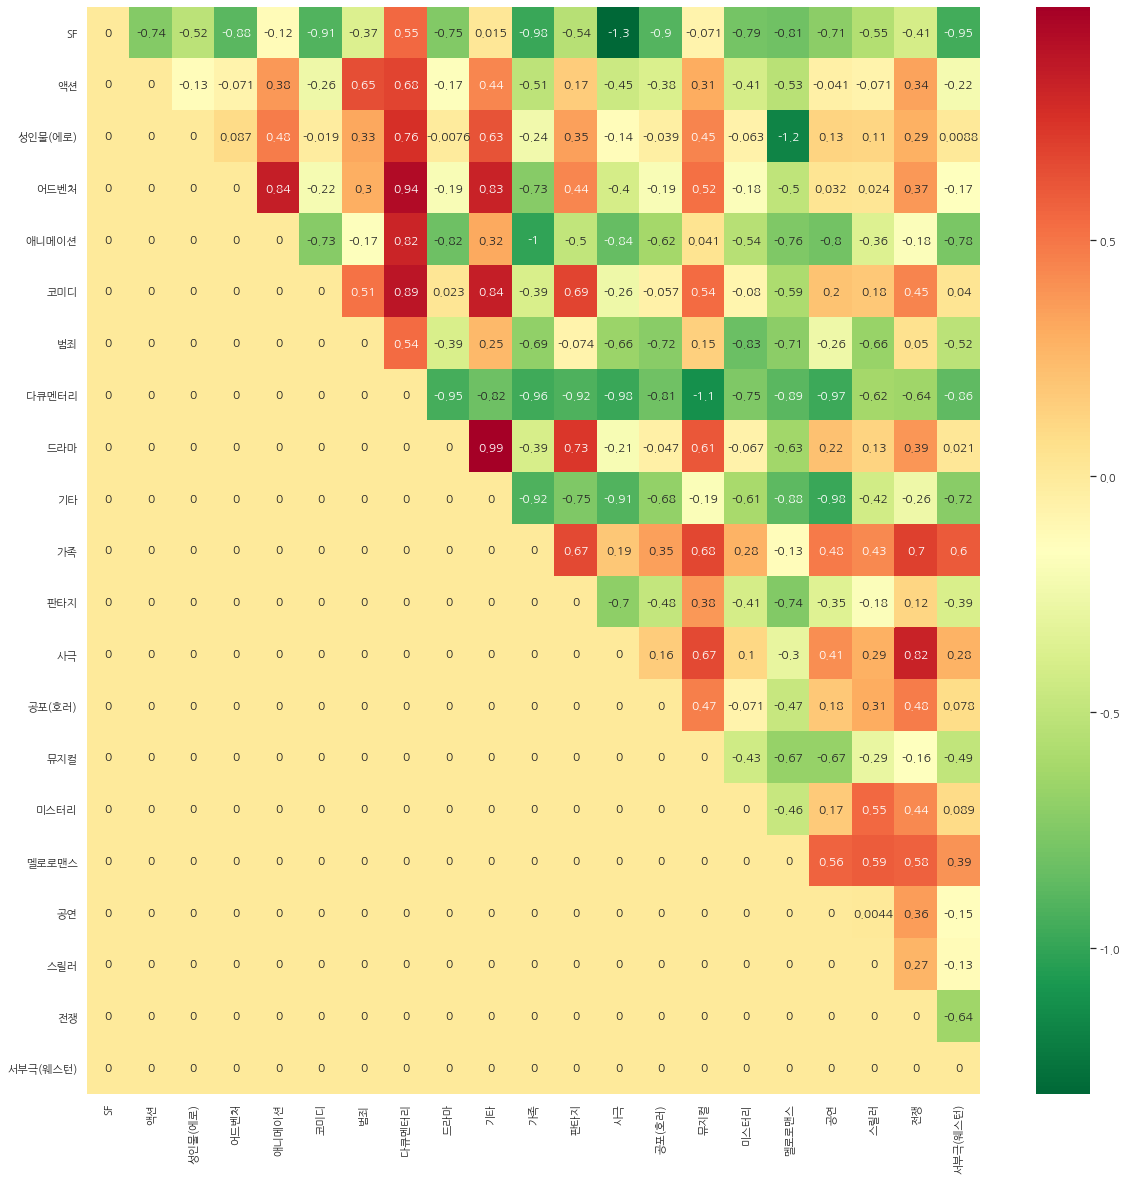

In [54]:
# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

sns.set(rc={'figure.figsize': (20, 20)}, font='NanumGothic')
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlGn_r')
ax